# Clustering with scikit-learn

We will use cluster analysis to generate a big picture model of the weather by using data from a local station (minute granularity data). Our
objective is to create 12 clusters.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#mport utils
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

%matplotlib inline

In [3]:
# dataset available here: https://github.com/words-sdsc/edX/blob/master/weather/minute_weather.csv.gz
data = pd.read_csv('weather/minute_weather.csv')

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [5]:
data.shape

(1587257, 13)

We sample down the data by including only one observation in 10 minutes, instead of one a minute

In [6]:
sampled_df = data[(data['rowID']) % 10 == 0]
sampled_df.shape

(158726, 13)

In [7]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [10]:
sampled_df[sampled_df.rain_accumulation == 0].shape
# not much rain accumulated

(157812, 13)

In [12]:
sampled_df[sampled_df.rain_duration == 0].shape
# the same about rain duration

(157237, 13)

### Our strategy is to drop all the rows with empty rain_accumulation and rain_duration as well as all rows containing NaN values

In [13]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [14]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

In [16]:
# we dropped
rows_before -rows_after

46

## Select features of interest for clustering

In [20]:
features = ['air_pressure', 'air_temp','avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed', 'relative_humidity']

In [21]:
select_df = sampled_df[features]

In [22]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


## Scale the feature by using StandardScaler

In [24]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

In [27]:
X.max()

14.154615859301948

## Use K-Means clustering

In [28]:
kmeans = KMeans(n_clusters = 12)
model = kmeans.fit(X)
print('model\n', model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [29]:
# get the centers of the clusters
centers = model.cluster_centers_
centers

array([[ 0.71667149,  0.44894203,  0.28550213, -0.53631985,  0.47279917,
        -0.54255693, -0.76669252],
       [-0.83765454, -1.20120114,  0.37557175,  0.36904555,  0.47403811,
         0.35702563,  1.36243665],
       [-0.21057891,  0.63296915,  0.40858054,  0.73350062,  0.51675564,
         0.67164628, -0.1516111 ],
       [-0.16370459,  0.8634041 , -1.31126777, -0.58955336, -1.16710698,
        -0.60484116, -0.64125855],
       [ 1.19007801, -0.25468312, -1.15493166,  2.12261318, -1.0534084 ,
         2.23936256, -1.13456932],
       [ 0.24471888, -0.99610161,  0.65809375, -0.547383  ,  0.8478918 ,
        -0.53015888,  1.16144381],
       [ 0.23405125,  0.32061871,  1.8879544 , -0.65181511, -1.55175807,
        -0.57669397, -0.28385048],
       [ 1.36768818, -0.08151489, -1.20649644, -0.0510817 , -1.07519624,
        -0.03084637, -0.97766689],
       [ 0.06113923, -0.78891905, -1.19730343, -0.5707786 , -1.0433185 ,
        -0.58536331,  0.87915471],
       [ 0.13262266,  0.8410

## Creating plots

In [30]:
# function to create a dataframe with a column for ClusterNumber

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    
    P = pd.DataFrame(Z, columns = colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [31]:
# function for parallel plotting

def parallel_plot(data):
    my_colors = list(islice(cycle(['b','r','g','y','k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker = 'o')

In [32]:
P = pd_centers(features, centers)

# Dry Days

/home/sgrosu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


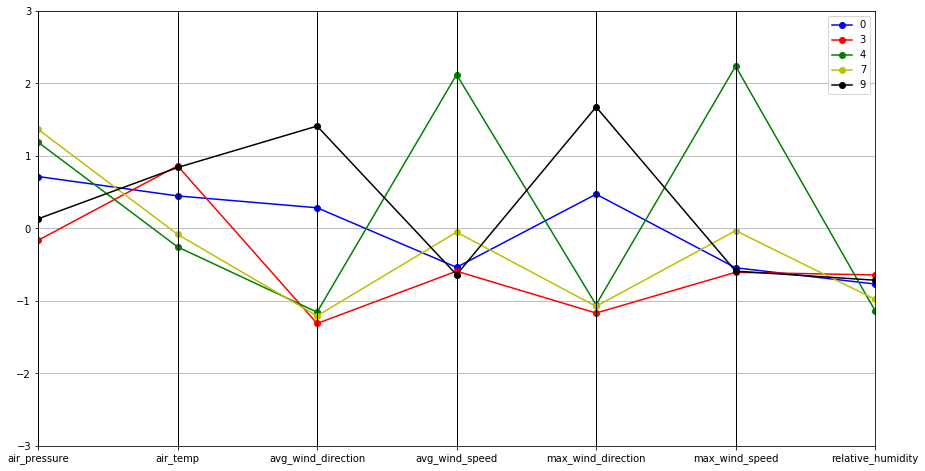

In [35]:
parallel_plot(P[P.relative_humidity< - 0.5])

/home/sgrosu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


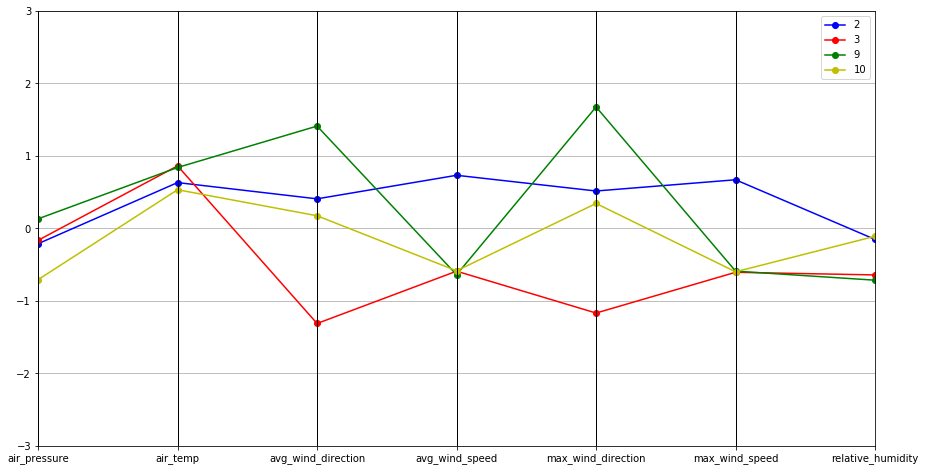

In [37]:
# warm days
parallel_plot(P[P.air_temp > 0.5])

/home/sgrosu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


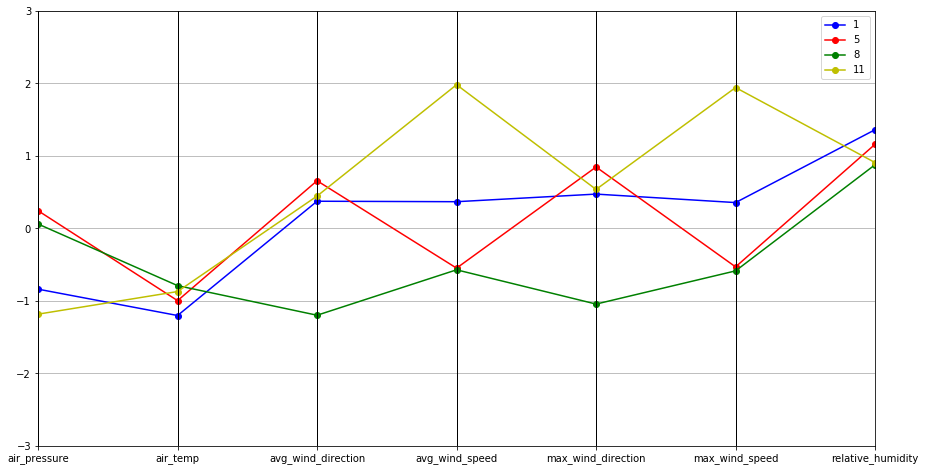

In [38]:
# cool days
parallel_plot(P[(P.relative_humidity > 0.5) & (P.air_temp < 0.5)])